# Import csv, numphy, tensorflow, dan juga sklearn model

In [89]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Menspesifikasikan Setiap Path

In [90]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Setting Class

In [91]:
NUM_CLASSES = 10

# Membaca Dataset

In [92]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [93]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Ngebuild Model

In [95]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [96]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_8 (Dropout)         (None, 42)                0         
                                                                 
 dense_12 (Dense)            (None, 20)                860       
                                                                 
 dropout_9 (Dropout)         (None, 20)                0         
                                                                 
 dense_13 (Dense)            (None, 10)                210       
                                                                 
 dense_14 (Dense)            (None, 10)                110       
                                                                 
Total params: 1,180
Trainable params: 1,180
Non-trainable params: 0
_________________________________________________________________


In [97]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [98]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Training model

In [99]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000


 1/14 [=>............................] - ETA: 6s - loss: 2.3077 - accuracy: 0.0938
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
14/14 [==============================] - 1s 12ms/step - loss: 2.3143 - accuracy: 0.0944 - val_loss: 2.2532 - val_accuracy: 0.1797
Epoch 2/1000
 1/14 [=>............................] - ETA: 0s - loss: 2.3210 - accuracy: 0.1016
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
14/14 [==============================] - 0s 5ms/step - loss: 2.2770 - accuracy: 0.1240 - val_loss: 2.2207 - val_accuracy: 0.2011
Epoch 3/1000
 1/14 [=>............................] - ETA: 0s - loss: 2.2492 - accuracy: 0.1641
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
14/14 [==============================] - 0s 5ms/step - loss: 2.2315 - accuracy: 0.1501 - val_loss: 2.1885 - val_accuracy: 0.2171
Epoch 4/1000
 1/14 [=>............................] - ETA: 0s - loss: 2.2263 - accuracy: 0.1484
Epoch 4: savi

In [100]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

5/5 [==============================] - 0s 2ms/step - loss: 0.9633 - accuracy: 0.6423


In [101]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [102]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 48ms/step
[1.9474095e-02 1.0117807e-01 3.2640782e-01 2.4843647e-01 2.2713096e-01
 7.6004446e-02 2.1012389e-04 1.7403559e-04 5.0809578e-04 4.7587149e-04]
2


# Confusion matrix

18/18 [==============================] - 0s 1ms/step


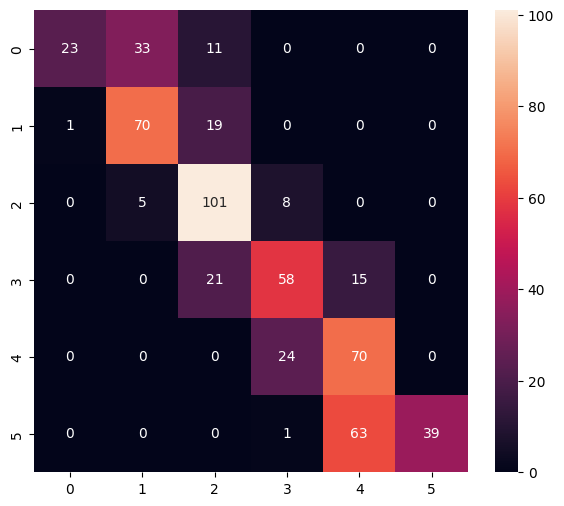

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.34      0.51        67
           1       0.65      0.78      0.71        90
           2       0.66      0.89      0.76       114
           3       0.64      0.62      0.63        94
           4       0.47      0.74      0.58        94
           5       1.00      0.38      0.55       103

    accuracy                           0.64       562
   macro avg       0.73      0.62      0.62       562
weighted avg       0.72      0.64      0.63       562



In [103]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [104]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [105]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\NATHAN~1\AppData\Local\Temp\tmphq783e2g\assets


INFO:tensorflow:Assets written to: C:\Users\NATHAN~1\AppData\Local\Temp\tmphq783e2g\assets


6872

# Inference test

In [106]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [107]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [108]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [109]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

Wall time: 0 ns


In [110]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1.9474089e-02 1.0117808e-01 3.2640794e-01 2.4843645e-01 2.2713089e-01
 7.6004401e-02 2.1012379e-04 1.7403539e-04 5.0809549e-04 4.7587120e-04]
2
